In This notebook we utilize the model previously created to run RUL prediction on the engines in the test data files.

In [1]:
import pandas as pd
import numpy as np
import math

import glob
import os
from tqdm.notebook import tqdm

# Setting seed for reproducability
np.random.seed(101)  
PYTHONHASHSEED = 0

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, GRU, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, TimeDistributed, Masking, Activation, RepeatVector


from sklearn import preprocessing
import joblib 

import sys
sys.path.insert(0,'../')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from data_generator import TSDataGenerator
import data_util
from util import set_log_dir, rmse, r2_keras
from model import *



/Users/lalu/Documents/Project-plus/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Setup

In [2]:
DATA_DIR = os.path.abspath("../dataset/")
MODEL_DIR = os.path.abspath("../model/")

In [3]:
cols = ['id', 'cycle' ]

# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]
cols.extend(setting_cols)

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
cols.extend(sensor_cols)

# The data already comes sorted, but to be on the safe we will 
# maintain an order based on engine and cycle and ascending cycle.
sort_cols = ['id','cycle']


### Load Model

In [4]:
# Feature columns. 
feature_cols = ['cycle_norm', 'condition']

# Label columns
label_cols = ['RUL']

# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]
feature_cols.extend(setting_cols)

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
feature_cols.extend(sensor_cols)


Keras requires that you use same batch size in predicting as you used when training. Here we will create the same model, but parameterize the shapes. This will allow us to specify a model with a batch size of 1. 

In [5]:
sequence_length = 25              # Size of the series time window.
batch_size = 1                    # Number of time series sequences that will predict on
num_features = len(feature_cols)
num_labels = len(label_cols)

model_path = sorted(glob.glob(MODEL_DIR+"/*/*.h5"), reverse=True)[1]
print("Loading model: ", model_path)

num_gru = 1

inf_model =model_gru(num_gru, sequence_length, num_features, num_labels)
inf_model.load_weights(model_path)
custom_objects={'rmse':rmse, 'r2_keras':r2_keras}
inf_model = load_model(model_path, custom_objects=custom_objects)

inf_model.summary()


Loading model:  /Users/lalu/Documents/Project-plus/RUL-Prediction-using-CNN-GRU/model/engine20220331T2125/engine_model.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (512, 256)                218112    
                                                                 
 dense (Dense)               (512, 64)                 16448     
                                                                 
 dense_1 (Dense)             (512, 32)                 2080      
                                                                 
 dense_2 (Dense)             (512, 1)                  33        
                                                                 
Total params: 236673 (924.50 KB)
Trainable params: 236673 (924.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Load Pipeline


In [6]:
pipeline_path = sorted(glob.glob(MODEL_DIR+"/*/*.pkl"), reverse=True)[1]
print("Loading pipeline: ", pipeline_path)

pipeline = joblib.load(pipeline_path) 

# from sklearn.pipeline import Pipeline
# from sklearn import preprocessing

# pipeline = Pipeline(steps=[
#     # The default activation function for LSTM tanh, so we'll use a range of [-1,1].
#     ('min_max_scaler', preprocessing.MinMaxScaler(feature_range=(-1, 1)))
# ])


Loading pipeline:  /Users/lalu/Documents/Project-plus/RUL-Prediction-using-CNN-GRU/model/engine20220331T2125/engine_pipeline.pkl


## Prediction

We will iterate over all the test files to run a prediction on a single batch for each engine's containing its last sequence_length events.

In [7]:
path = os.path.join(DATA_DIR, "test_FD*.txt")
all_test_files = sorted(glob.glob(path))

path = os.path.join(DATA_DIR, "RUL_FD*.txt")
all_rul_files = sorted(glob.glob(path))

all_test_files

['/Users/lalu/Documents/Project-plus/RUL-Prediction-using-CNN-GRU/dataset/test_FD001.txt',
 '/Users/lalu/Documents/Project-plus/RUL-Prediction-using-CNN-GRU/dataset/test_FD002.txt',
 '/Users/lalu/Documents/Project-plus/RUL-Prediction-using-CNN-GRU/dataset/test_FD003.txt',
 '/Users/lalu/Documents/Project-plus/RUL-Prediction-using-CNN-GRU/dataset/test_FD004.txt']

In [9]:
test_prediction_results = []

for i, test_X_path in enumerate(all_test_files):
    # Read in the features
    test_df = data_util.load_data([test_X_path], cols, sort_cols)

    # Read in the labels (RUL)
    test_rul_df = data_util.load_rul_data([all_rul_files[i]], ['id', 'RUL_actual'])

    # Calculate the RUL and merge back to the test dataframe
    test_df = data_util.calc_test_rul(test_df, test_rul_df)

    # # Transform
    test_df = data_util.transform(test_df, pipeline)
    
    results = []

    for engine_id in tqdm(test_df['id'].unique()):
        engine_df = test_df[ test_df['id'] == engine_id]

        # The last sequence_length entries are used for the batch.
        # Skip the engines with less then sequence_length for now.
        # TODO support padding
        if engine_df.shape[0] > sequence_length:
            last_batch = engine_df[feature_cols].iloc[-sequence_length:].values.reshape(batch_size, sequence_length, num_features)
            rul = engine_df['RUL'].iloc[-1:].values[0]
            prediction = inf_model.predict_on_batch(last_batch)[0,0]

            results.append([engine_id, prediction, rul, prediction-rul])
            
    test_prediction_results.append(np.array(results))
    

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Plot the results by engine id. Those predictions above zero have over-estimated the actual RUL, while those below zero under-estimate the RUL. It is preferable to be less optimistic.

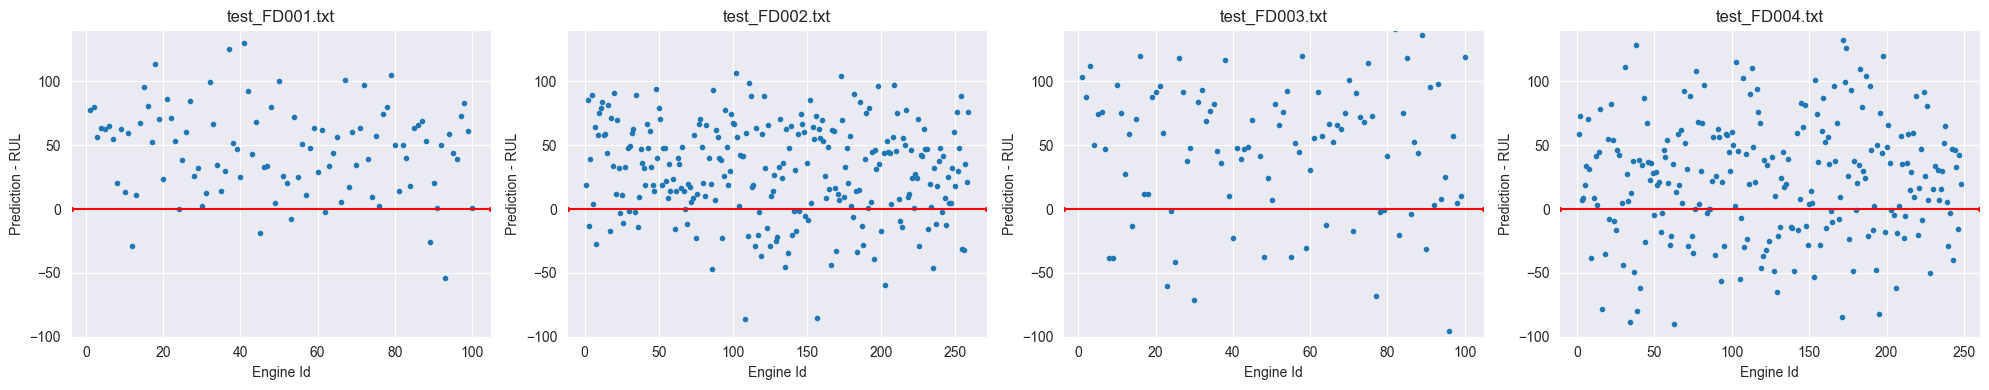

In [10]:
sns.set_style('darkgrid')

fig = plt.figure(figsize=(20, 4))
for i, r in enumerate(test_prediction_results):
    ax = plt.subplot(1, 4, i+1)
    # Subtract the base to show the original engine id
    ax.scatter(r[:,0] - data_util.path_to_id_base(all_test_files[i]), r[:,3], marker='.',)
    ax.set_ylim(-100, 140)
    ax.set_xlabel("Engine Id")
    ax.set_ylabel("Prediction - RUL")
    ax.set_title(os.path.basename(all_test_files[i]))

    ax.axhline(y=0, color='r', marker='.')

plt.tight_layout()
plt.show()

The histogram illustrates the bins that the differences fall in.

/var/folders/b7/hg813cjd6151wzlnz64tbqbm0000gn/T/ipykernel_25828/2675309004.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(r[:,3], ax=ax2)
/var/folders/b7/hg813cjd6151wzlnz64tbqbm0000gn/T/ipykernel_25828/2675309004.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(r[:,3], ax=ax2)
/var/fol

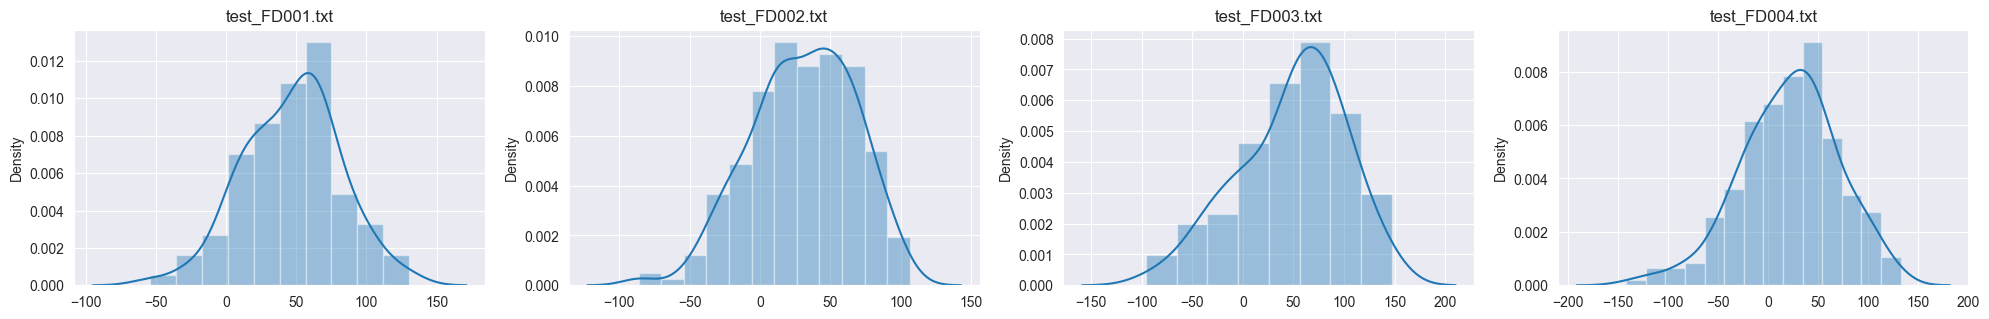

In [11]:
sns.set_style('darkgrid')

fig = plt.figure(figsize=(20, 6))
for i, r in enumerate(test_prediction_results):
    ax2 = plt.subplot(2, 4, i+5)
    sns.distplot(r[:,3], ax=ax2)
    ax2.set_title(os.path.basename(all_test_files[i]))


plt.tight_layout()
plt.show()

Let's plot a single file for a close-up view.

In [12]:
file_index = 1  # 1 is test_FD002
results = test_prediction_results[file_index]
base_id = data_util.path_to_id_base(all_test_files[file_index])

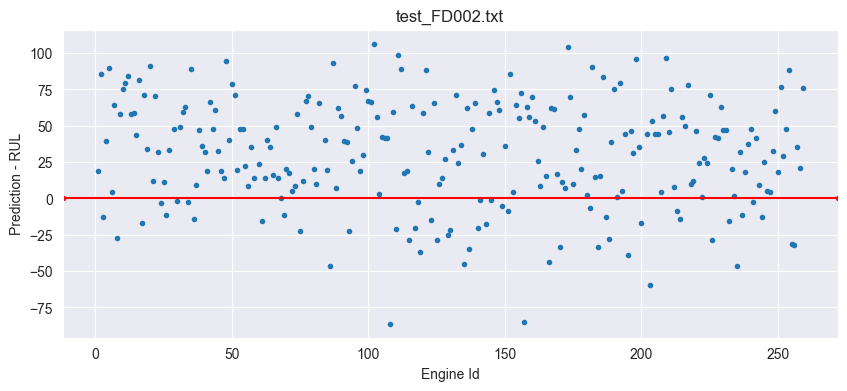

In [13]:
fig = plt.figure(figsize=(10, 4))
plt.scatter(results[:,0] - base_id, results[:,3], marker='.', label="Diff")
plt.xlabel("Engine Id")
plt.ylabel("Prediction - RUL")
plt.title(os.path.basename(all_test_files[file_index]))

plt.axhline(y=0, color='r', marker='.')

plt.show()


This is another view based on the RUL. The red line indicates what perfect prediction would have looked like. The majority of the predictions were optimistic.

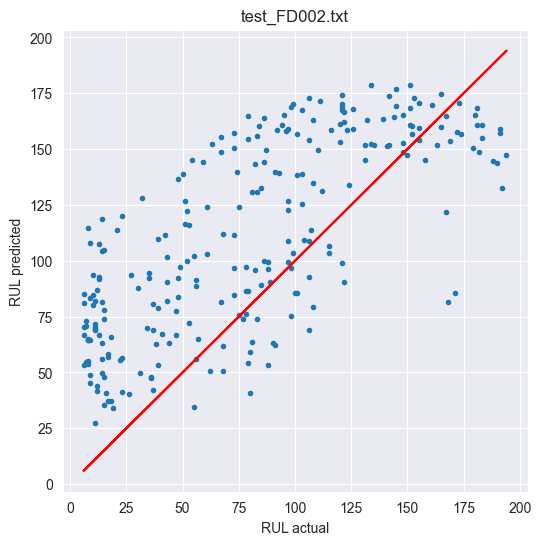

In [14]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(results[:,2], results[:,1], marker='.')
plt.plot(results[:,2], results[:,2], 'r')
plt.xlabel("RUL actual")
plt.ylabel("RUL predicted")
plt.title(os.path.basename(all_test_files[file_index]))

plt.show()


Show the prediction of 3 randomly selected engines from each test file.

In [15]:
test_prediction_results = []

for i, test_X_path in enumerate(all_test_files):
    # Read in the features
    test_df = data_util.load_data([test_X_path], cols, sort_cols)

    # Read in the labels (RUL)
    test_rul_df = data_util.load_rul_data([all_rul_files[i]], ['id', 'RUL_actual'])

    # Calculate the RUL and merge back to the test dataframe
    test_df = data_util.calc_test_rul(test_df, test_rul_df)

    # Transform
    test_df = data_util.transform(test_df, pipeline)
    
    results = []
    
    # Filter out those two small to fit a complete sequence. See padding
    candidates = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
    candidates = candidates[ candidates['cycle'] >= sequence_length ]

    engine_ids = np.random.choice(candidates['id'], 3)
    for engine_id in engine_ids:
        engine_df = test_df[ test_df['id'] == engine_id]
        
        start_idx = 0
        end_idx = start_idx + sequence_length
        while end_idx < engine_df.shape[0]:
            
            last_batch = engine_df[feature_cols].iloc[start_idx:end_idx].values.reshape(batch_size, sequence_length, num_features)
            rul = engine_df['RUL'].iloc[end_idx]
            cycle = engine_df['cycle'].iloc[end_idx]

            prediction = inf_model.predict_on_batch(last_batch)[0,0]

            results.append([engine_id, cycle, prediction, rul])
            
            start_idx += 1
            end_idx += 1
                        
        test_prediction_results.append(np.array(results))
        results = []

    

In [16]:
len(results)

0

In [17]:
len(test_prediction_results)

12

In [18]:
len(test_prediction_results[0])

72

In [19]:
len(test_prediction_results[0][0])

4

In [20]:
test_prediction_results[0]

array([[5096.        ,   26.        ,  192.50190735,  208.        ],
       [5096.        ,   27.        ,  192.27183533,  207.        ],
       [5096.        ,   28.        ,  191.77784729,  206.        ],
       [5096.        ,   29.        ,  191.03340149,  205.        ],
       [5096.        ,   30.        ,  190.85368347,  204.        ],
       [5096.        ,   31.        ,  190.22644043,  203.        ],
       [5096.        ,   32.        ,  190.48513794,  202.        ],
       [5096.        ,   33.        ,  191.10624695,  201.        ],
       [5096.        ,   34.        ,  191.46084595,  200.        ],
       [5096.        ,   35.        ,  191.47187805,  199.        ],
       [5096.        ,   36.        ,  190.86981201,  198.        ],
       [5096.        ,   37.        ,  191.60725403,  197.        ],
       [5096.        ,   38.        ,  191.38104248,  196.        ],
       [5096.        ,   39.        ,  190.14910889,  195.        ],
       [5096.        ,   40.      

In [21]:

def display_engine_prediction(prediction_results):
    """ Plots prediction results for a set of engines.
    
    Args:
    prediction_results (list) - List of engine arrays of shape (cycle, 4). Where
    the columns represent engine_id, cycle, prediction, RUL.
    
    """
        
    # Total plots 
    n = len(prediction_results)
     
    ncols = max(n//3,1)
    nrows = math.ceil(n/ncols)
        
    fig = plt.figure(figsize=(20, 10))
    
    for i, r in enumerate(prediction_results):
        
        engine_id = r[0,0]
        cycle = r[:,1]
        prediction = r[:,2]
        rul = r[:,3]

        ax = plt.subplot(nrows, ncols, i+1)

        l1, = ax.plot( cycle, rul, label='RUL')
        l2, = ax.plot( cycle, prediction, label='Prediction')
        ax.set_xlabel('cycle')
        ax.set_ylabel('RUL')
        ax.set_ylim(0)
        plt.title("Engine: {:.0f}".format(engine_id))
                
    fig.legend((l1,l2), ('Actual', 'Prediction'), 'upper right')
    plt.tight_layout()
    
    plt.show()

/var/folders/b7/hg813cjd6151wzlnz64tbqbm0000gn/T/ipykernel_25828/3446140717.py:34: MatplotlibDeprecationWarning: Passing the loc parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  fig.legend((l1,l2), ('Actual', 'Prediction'), 'upper right')


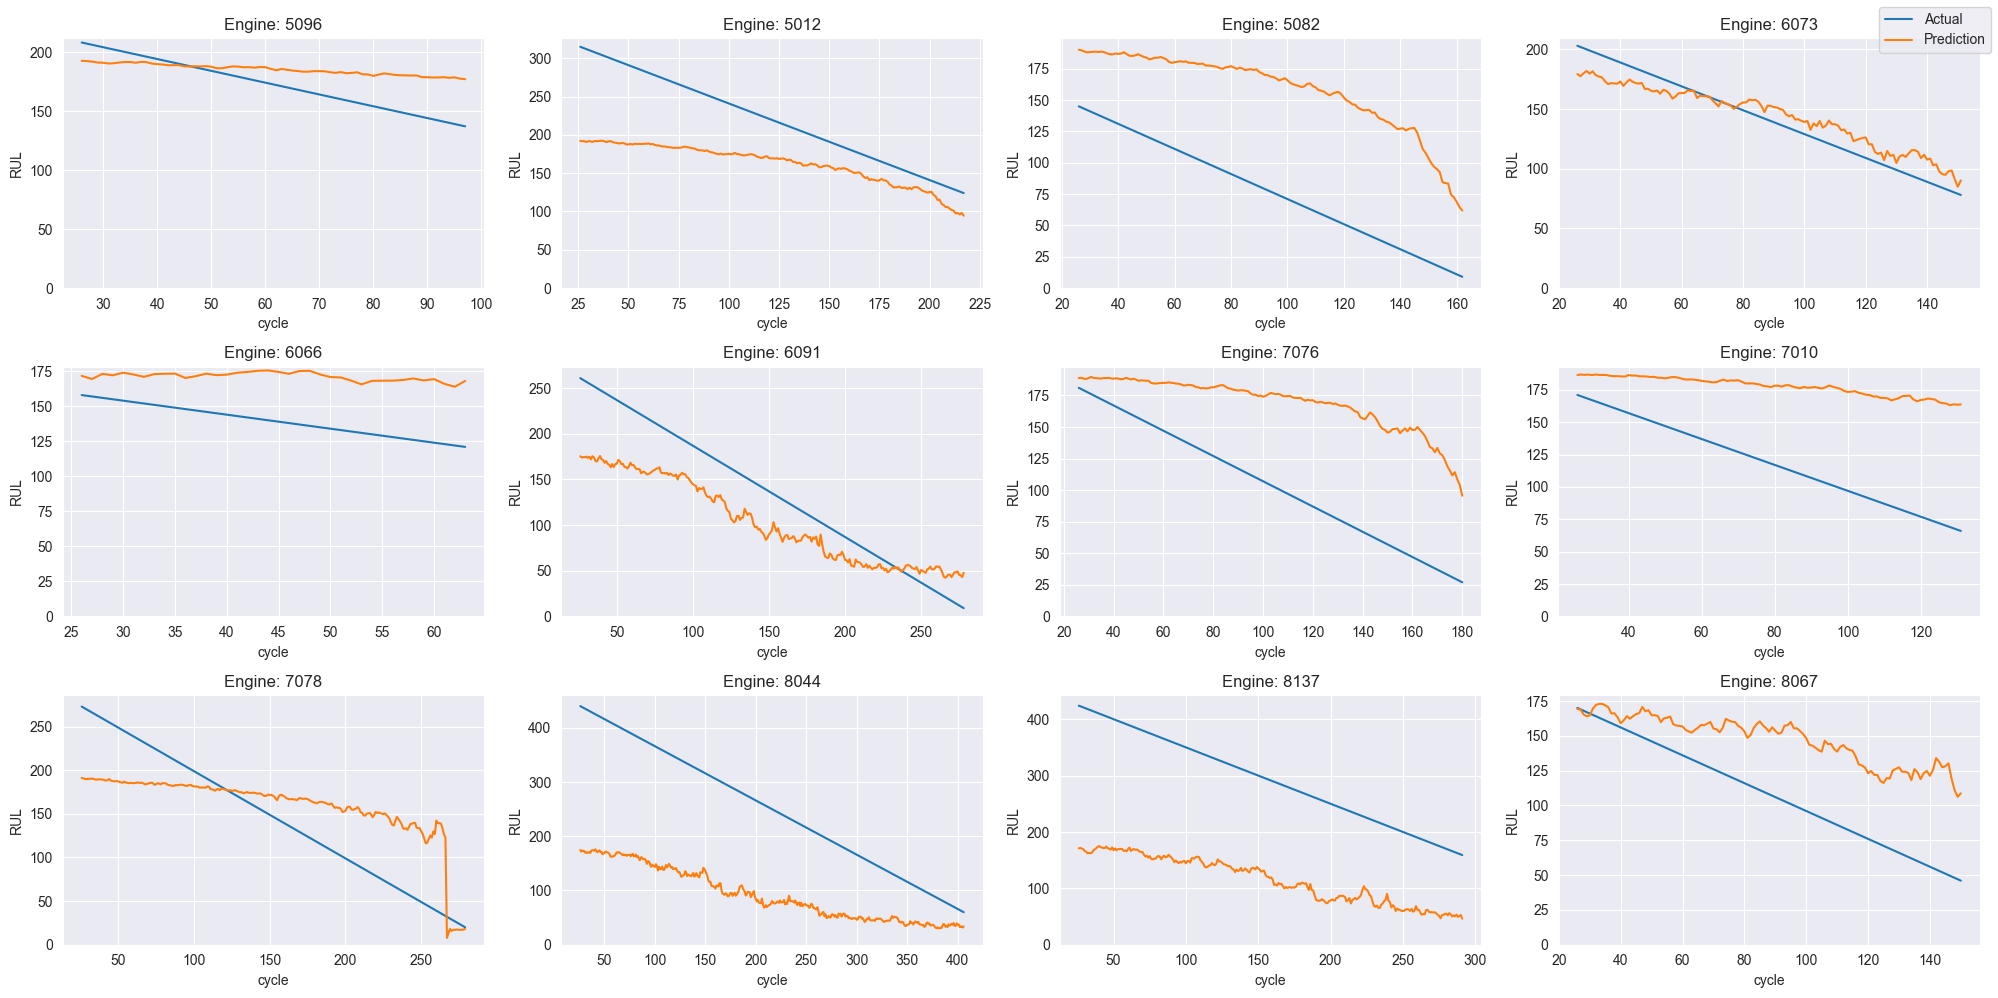

In [22]:
display_engine_prediction(test_prediction_results)

In [23]:
test_prediction_results = []


for i, tmp_X_path in enumerate(all_test_files):
    # Read in the features
    tmp_df = data_util.load_data([tmp_X_path], cols, sort_cols)

    # Read in the labels (RUL)
    tmp_rul_df = data_util.load_rul_data([all_rul_files[i]], ['id', 'RUL_actual'])

    # Calculate the RUL and merge back to the test dataframe
    tmp_df = data_util.calc_test_rul(tmp_df, tmp_rul_df)

    # Transform
    tmp_df = data_util.transform(tmp_df, pipeline)
    
    results = []

    for engine_id in tqdm(tmp_df['id'].unique()):
        engine_df = tmp_df[ tmp_df['id'] == engine_id]
        
        # The last sequence_length entries are used for the batch.
        # Skip the engines with less then sequence_length for now.
        # TODO support padding
        if engine_df.shape[0] >= sequence_length:
            last_batch = engine_df[feature_cols].iloc[-sequence_length:].values.reshape(batch_size, sequence_length, num_features)

        else:
            gap = engine_df.shape[0] % sequence_length
            num_pad_rows = sequence_length - gap
            pad_df = pd.DataFrame(np.zeros((num_pad_rows, num_features)),
                                  columns=feature_cols)
            last_batch = pd.concat([pad_df, engine_df[feature_cols]]).values.reshape(batch_size, sequence_length, num_features)
            padded_batch = last_batch
            
        rul = engine_df['RUL'].iloc[-1:].values[0]
        prediction = inf_model.predict_on_batch(last_batch)[0,0]

        results.append([engine_id, prediction, rul, prediction-rul])

        assert (last_batch.shape[1] % sequence_length) == 0     
        
    test_prediction_results.append(np.array(results))



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

In [24]:
len(test_prediction_results)

4

In [25]:
len(test_prediction_results[0])

100

In [26]:
test_prediction_results[0][0]

array([5001.       ,  189.4342041,  112.       ,   77.4342041])

In [27]:
test_prediction_results[0][1]

array([5002.       ,  177.6428833,   98.       ,   79.6428833])